# Alex Ten study

In this study, we have several tasks. For each task, the user can choose one of two actions, and can receive a binary feedback (failure or success). We define $p$, the user subjective estimation of the success probability.

Here, I explore one lead on how to model switching between task. In particular, I propose a heuristic to leave one task.

I suggest that a task can be left, whenever the user think it is in one of two cases:
1. It solved the task, $p$ close to $1$.
2. It thinks the task is impossible $p=0.5$. This can happen because the task gives random feedback, or because the user didn't figure out the pattern.

I propose to use two corresponding statistical tests:
1. A Normal test to test for $p=1$.
2. A normal test for $p=0.5$

The user might switch whenever:
- the test for $p=1$ does not reject the null hypothesis ($H_0$: $p=1$), with a certain level of confidence $\alpha_1$(that might be shared across users, inidivual dependent or that might depend on the user type of strategy).
- the test for $p=0.5$ does not reject the null hypothesis ($H_0$: $p=0.5$), with a certain level of confidence $\alpha_{05}$ (that might be shared across users, inidivual dependent or that might depend on the user type of strategy).

This means that the evidence accumulated so far does not refute the hypothesis of the user, i.e. 1) he's solved it, 2) he's hopeless.

This statistics needs to be computed on a certain time window. I propose that when the user starts targeting a new task (or gets back to it after having tackling another), we do not use previous information. However, we should consider a moving window. If the user tackles task 1 for 50 episodes, it might be the case that it didn't figure it out at first and figured it out in the end. The computation of the test should only consider the $n$ last trials. Here again, $n$ might be a parameter shared across user, indiviual, or shared in groups of user.

Let's see some simulation to illustrate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.special import comb

%matplotlib inline

def p_val(n, k, p):
    return comb(n, k) * p ** k * (1 - p) ** (n - k)

Here we set parameters

In [2]:
alpha1 = 0.1
alpha05 = 0.3
n = 5

Below, probas spans possible true probabilities of success from $0$ to $1$. 
For each possible value of that probability, we draw a sequence of outcomes and compute:
1. The likelihood of observing that outcomes given the true underlying probability $p$.
2. The z-score of the test for $p=1$. Here we consider a 1-tail testn as the true probability cannot be higher that $1$.
3. The z-score of the test for $p=0.5$. Here we consider a 2-tail test, as the true probability could be either above or below the 0.5 level.

Here we test the number of successes $n_s$ and compute Z such as:
$$ Z = \frac{n_s - n \times p}{\sqrt{n\times p(1-p)}}$$

In [3]:
probas = np.arange(0,1.01,0.01)
l = np.zeros([probas.size]) # likelihood
z05 = np.zeros([probas.size]) # z-score 0.5
z1 = np.zeros([probas.size]) # z-score 1

l05 = np.zeros([probas.size])
l1 = np.zeros([probas.size])


We compute the limit z-score value associated to the alpha levels of confidence $z_{\alpha-05}$ and $z_{\alpha-1}$.

In [4]:
coeff_alpha1 = st.norm.ppf(1-alpha1)
print('coeff_alpha1: ', coeff_alpha1)
coeff_alpha05 = st.norm.ppf(1-alpha05/2)
print('coeff_alpha05: ', coeff_alpha05)

coeff_alpha1:  1.2815515655446004
coeff_alpha05:  1.0364333894937898


In [5]:
p_test05 = 0.5
std05 = np.sqrt(n * p_test05 * (1 - p_test05))
mean05 = n * p_test05
z_alpha05 = [-coeff_alpha05 * std05, coeff_alpha05 * std05] # defines z alpha

# here we use 0.9 instead of 1, as testing for 1 produces 
# a dirac instead of a normal distribution (std = p (1-p)=0).
# Indeed, the first failure is incompatible with p=1 and the test rejects the 
# null hypothesis no matter the required confidence level.

p_test1 = 0.9
std1 = np.sqrt(n * p_test1 * (1 - p_test1))
mean1 = n * p_test1
z_alpha1 = [-coeff_alpha1 * std1] # defines z alpha

Now we run the actual simulations

In [6]:
sims = []
for i, true_p in enumerate(probas):
    # draw outcomes
    outcomes = np.random.choice([0, 1], p=[1 - true_p, true_p], size=n)
    sims.append(outcomes)
    s = outcomes.sum()

    l[i] = true_p ** s * (1 - true_p) ** (n - s)

    z05[i] = (s - mean05) / std05
    z1[i] = (s - mean1) / std1
    
    l05[i] =  p_val(n, s, .5)
    l1[i] =  p_val(n, s, .9)

Text(0.5,1,'Likelihood')

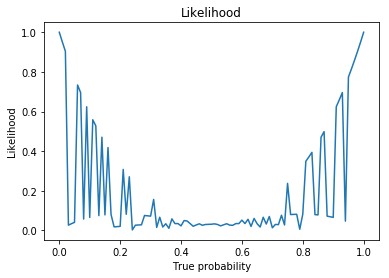

In [7]:
plt.figure()
plt.plot(probas, l)
plt.xlabel('True probability')
plt.ylabel('Likelihood')
plt.title('Likelihood')

Below, we plot the empirical z-score for the test $p=0.5$ when the true underlying probability is x.
The red lines represent the limit z-statistics such that having a z-score above or lower results in a rejection of the test $p=0.5$ with a confidence level $\alpha_{05}$.
In practice, the agent could compute its Z-score, and switch after $M$ exploration episodes if it did not get out of the area between the two lines. This means the outcomes did not bring him enough evidence to reject the hypothesis: "I understand someting about that task".

Text(0.5,1,'z05')

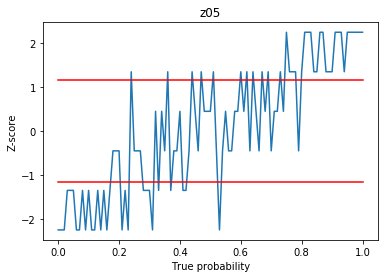

In [8]:
plt.figure()
plt.plot(probas, z05)
plt.plot(probas, z_alpha05[0] * np.ones([probas.size]), c='r')
plt.plot(probas, z_alpha05[1] * np.ones([probas.size]), c='r')
plt.xlabel('True probability')
plt.ylabel('Z-score')
plt.title('z05')

Below, we plot the empirical z-score for the test $p=1$ when the true underlying probability is x.
The red line represents the limit z-statistic such that having a lower z-score results in a rejection of the test $p=1$ with a confidence level $\alpha_{1}$.
In practice, the agent could compute its Z-score, and switch when the z-score reaches that limit. When it does, it means that the outcomes did not show him enough evidence to prove that it did not understand the task. We could think of it the other way: the evidence showed him he can be $alpha_1$ confident that he understood the task (although mathematically speaking this assertion is not true, here we're talking about human heuristics).


Text(0.5,1,'z1')

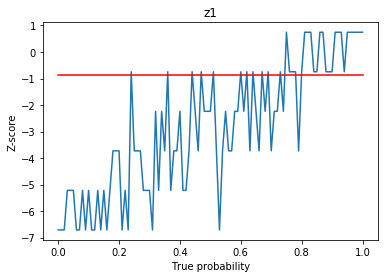

In [9]:
plt.figure()
plt.plot(probas, z1)
plt.plot(probas, z_alpha1[0] * np.ones([probas.size]), c='r')
plt.xlabel('True probability')
plt.ylabel('Z-score')
plt.title('z1')


Text(0.5,1,'pval05')

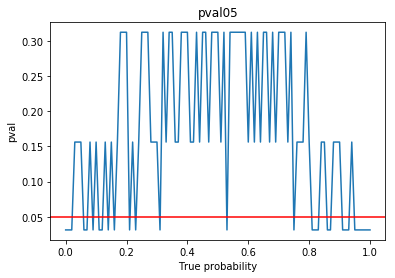

In [10]:
plt.figure()
plt.plot(probas, l05)
plt.xlabel('True probability')
plt.axhline(.05, c='r')
plt.ylabel('pval')
plt.title('pval05')

Text(0.5,1,'pval1')

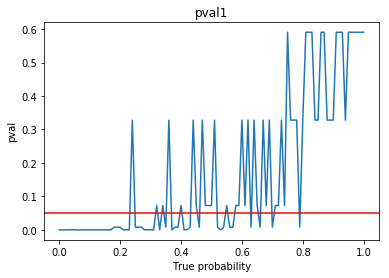

In [11]:
plt.figure()
plt.plot(probas, l1)
plt.axhline(.05, c='r')
plt.xlabel('True probability')
plt.ylabel('pval')
plt.title('pval1')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log2
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


<IPython.core.display.Javascript object>


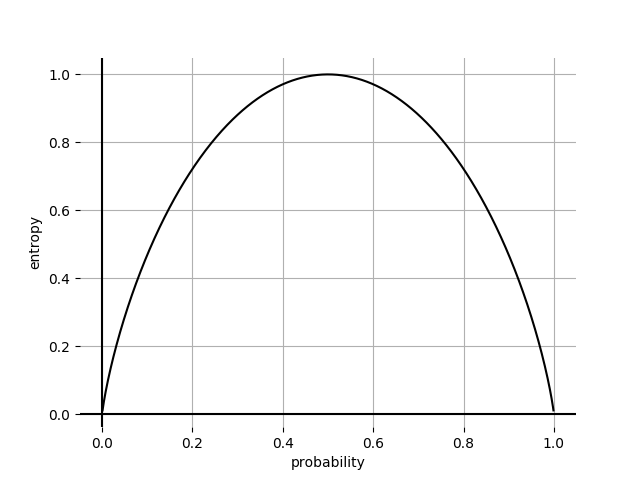

Text(0,0.5,'entropy')

In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from vis_utils import despine

p = np.linspace(0.001,1,1000)
H = -p * np.log2(p) - (1-p)*np.log2(1-p)

plt.plot(p, H, c='k')
plt.grid(True)
despine(plt.gca(), ['top','right', 'left', 'bottom'])
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.xlabel('probability')
plt.ylabel('entropy')
